# 須恵器の擬似修復テストコード

## データ準備

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 回転復元対象の須恵器OBJファイルの用意
!cp -r /content/drive/MyDrive/20240821_sueki_complement ./

In [ ]:
# グラフ描画用Pythonライブラリmatplotlibの日本語化用ライブラリ
!pip install -q japanize-matplotlib

# mesh処理・可視化用のPythonライブラリ：trimeshとpyvista のインストール
!pip install -q trimesh pyvista
!apt install -qq xvfb libgl1-mesa-glx

# mesh可視化用のPythonライブラリ：pyvista の設定
from google.colab import output
output.enable_custom_widget_manager()

import pyvista as pv
pv.set_jupyter_backend('static')
pv.global_theme.notebook = True
pv.start_xvfb()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 6.9 MB/s eta 0:00:00
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libgl1-mesa-glx libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 10 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,819 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123605 files and directories currently installed.)
Prepar

## 修復対象の須恵器

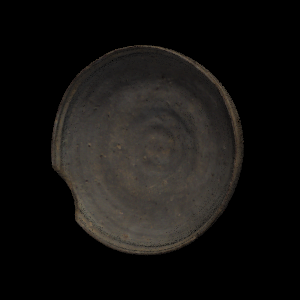

In [ ]:
import pyvista as pv

# 入力ファイル名の設定
obj_filename = "/content/20240821_sueki_complement/J-11536f.obj"
texture_filename = "/content/20240821_sueki_complement/J-11536.bmp"

# 出力画像ファイル名の指定
screenshot_filename = 'screenshot_J-11536.png'

# meshが定義されているファイル(obj)と，textureが定義されているファイル(bmp)を読み込む
mesh = pv.read(filename = obj_filename, force_ext = None, file_format = None, progress_bar = False)
tex = pv.read_texture(filename = texture_filename, progress_bar = False)

#plotterの用意
plotter = pv.Plotter(notebook = True, off_screen = False, window_size = [300, 300])
plotter.add_mesh(mesh = mesh, texture = tex)

# 背景色設定
plotter.set_background(color = [0, 0, 0])


#pyvistaによるカメラ位置定義
#cameraAngle_list = ['xy', 'xz', 'yz', 'yx', 'zx', 'zy', 'iso']
plotter.camera_position = 'iso'


# 方位角･仰角･偏波角 の調整
plotter.camera.elevation += 150
plotter.camera.roll += -10
plotter.camera.azimuth += 70

plotter.show(auto_close = False, screenshot = screenshot_filename)
plotter.close()

## 口縁部の欠損角度を特定

近似円 
 中心: [-0.00091292  0.00016512] 
 半径: 0.06671175313458858
欠損部位の角度： 194.76°から 228.44° (33.68°)


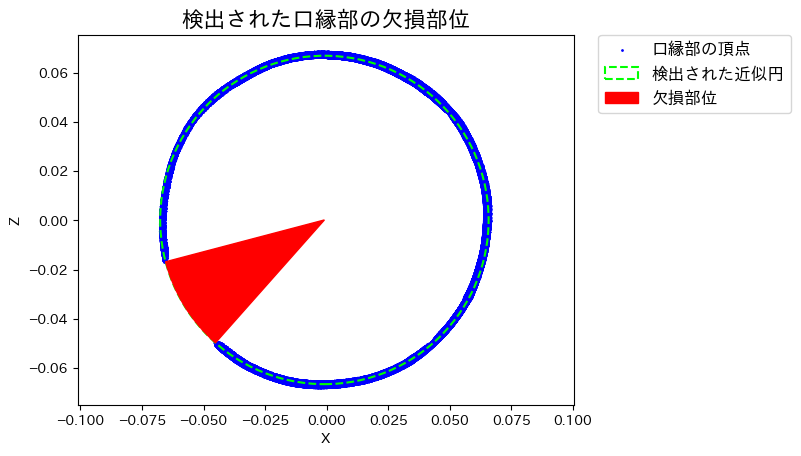

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.optimize import leastsq
import trimesh
import japanize_matplotlib


# 須恵器（蓋） OBJファイル の読み込み（注：本サンプルデータの須恵器は，Y座標が縦軸）
mesh = trimesh.load('/content/20240821_sueki_complement/J-11536f.obj')

#【須恵器・蓋の場合】
# 口縁部の頂点抽出（Y座標の下部にある頂点を想定）
# Y座標の最小値に近い頂点（5パーセンタイル未満）を取得
y_threshold = np.percentile(mesh.vertices[:, 1], 5)  # 5パーセンタイルの頂点を選択
rim_vertices = mesh.vertices[mesh.vertices[:, 1] < y_threshold]

#【須恵器・身の場合】
# 口縁部の頂点抽出（Y座標の上部にある頂点を想定）
# Y座標の最大値に近い頂点（95パーセンタイルより大きい）を取得
# y_threshold = np.percentile(mesh.vertices[:, 1], 95)  # 95パーセンタイルの頂点を選択
# rim_vertices = mesh.vertices[mesh.vertices[:, 1] > y_threshold]


# X-Z平面上の頂点座標を取得
#（注：本サンプルデータの須恵器はY座標が縦軸であるため，X座標とZ座標を取得）
x = rim_vertices[:, 0]
z = rim_vertices[:, 2]


# 円形近似用の関数
def fit_circle(x, y):
    # 円形近似用の最小二乗法
    def calc_R(xc, yc):
        return np.sqrt((x - xc) ** 2 + (y - yc) ** 2)

    def residuals(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    # 初期推定値はデータ点の平均値とする (xc, yc)
    center_estimate = np.mean(x), np.mean(y)
    center, ier = leastsq(residuals, center_estimate)

    Ri = calc_R(*center)
    R = Ri.mean()
    return center, R


# 口縁部の頂点に近いデータ点で円形近似
(center, radius) = fit_circle(x, z)
print(f"近似円 \n 中心: {center} \n 半径: {radius}")

# 欠けの検出（閾値以内に頂点が存在しない場合，欠損していると仮定する）
threshold = 0.05  # 5%のずれを許容
distances = np.sqrt((x - center[0])**2 + (z - center[1])**2)
deviation = np.abs(distances - radius)

# 円周上の角度を計算 (X-Y平面での極座標変換)
angles = np.arctan2(z - center[1], x - center[0])
angles = np.rad2deg(angles)  # ラジアンを度に変換
angles = np.mod(angles, 360)

# 角度差の閾値を1度に設定
angle_diff_threshold = 1

# 頂点の角度を並び替え，角度差を計算
sorted_indices = np.argsort(angles)
sorted_angles = angles[sorted_indices]

# 連続する角度の差を計算，angle_diff_threshold（1度）以上の差があれば欠損として検出
angle_diffs = np.diff(np.concatenate([sorted_angles, [sorted_angles[0] + 360]]))  # 最後の角度と最初の角度を考慮
missing_sections = np.where(angle_diffs > angle_diff_threshold)[0]


# 閾値以内から外れた頂点がある場合，「歪み」として定義する
warped_indices = np.where(deviation > threshold * radius)[0]
warped_vertices = rim_vertices[warped_indices]
warped_angles = angles[warped_indices]



# 可視化
# 抽出した頂点の描画
s = np.full(len(x), 1)
plt.scatter(x = x, y = z, color = 'blue', label = '口縁部の頂点', s = s)
# 近似円の描画
circle = plt.Circle(xy = center, radius = radius, color = 'lime', fill = False, label = '検出された近似円', linewidth = 1.5, linestyle = '--')
plt.gca().add_artist(circle)

# 欠損部分の開始角度と終了角度を描画
for section in missing_sections:
    start_angle = sorted_angles[section]
    end_angle = sorted_angles[section + 1] if section + 1 < len(sorted_angles) else sorted_angles[0] + 360
    missing_angle_range = end_angle - start_angle

    print(f"欠損部位の角度： {start_angle:.2f}°から {end_angle:.2f}° ({missing_angle_range:.2f}°)")

    arc = patches.Wedge(center = center, r = radius, theta1 = start_angle, theta2 = end_angle, color = 'red', label = '欠損部位')
    plt.gca().add_artist(arc)

# 閾値以内から外れた頂点がある場合は，「歪み部位」として描画
if len(warped_vertices):
    s = np.full(len(warped_vertices), 1)
    plt.scatter(x = warped_vertices[:, 0], y = warped_vertices[:, 2], color = 'orange', label = '歪み部位の頂点', s = s)

plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left', borderaxespad = 0, fontsize = 12)
plt.axis('equal')
plt.xlabel(xlabel = 'X')
plt.ylabel(ylabel = 'Z')
plt.title(label = '検出された口縁部の欠損部位', fontsize = 16)
plt.show()

## 縦軸周りの回転による須恵器の擬似修復

In [ ]:
import trimesh
import numpy as np



# 須恵器（蓋） OBJファイル の読み込み（注：本サンプルデータの須恵器は，Y座標が縦軸）
mesh = trimesh.load('/content/20240821_sueki_complement/J-11536f.obj')

# 軸周りに回転させる関数
def rotate_around_axis(mesh, angle_degrees, rotation_axis, origin_point = [0, 0, 0]):
    # 角度をラジアンに変換
    angle_radians = np.deg2rad(angle_degrees)
    # 軸周りの回転行列
    rotation_matrix = trimesh.transformations.rotation_matrix(angle = angle_radians, direction = rotation_axis, point=origin_point)
    # メッシュを回転（copyしないとreturnで元のmeshが返る）
    rotated_mesh = mesh.copy()
    rotated_mesh.apply_transform(matrix = rotation_matrix)
    return rotated_mesh


# 回転時の中心点，および回転行列の定義

# 回転時の中心点を定義
# 中心点として，原点を使用する場合
origin_point = [0, 0, 0]
# 中心点として，近似円の中心座標を使用する場合（注：本サンプルデータの須恵器は，Y座標が縦軸）
#origin_point = [center[0], 0, center[1]]

# 縦軸周りの回転行列を設定
# 回転行列（Y軸周りの回転）
rotation_axis = [0, 1, 0]

# 50度回転した須恵器を生成・結合
rotated_meshes = []
for angle in np.linspace(start = 0, stop = 50, num = 2):
    rotated_mesh = rotate_around_axis(mesh = mesh, angle_degrees = angle, rotation_axis = rotation_axis, origin_point = origin_point)
    rotated_meshes.append(rotated_mesh)

# 回転した全メッシュを結合
combined_mesh = trimesh.util.concatenate(rotated_meshes)
combined_mesh.update_faces(combined_mesh.nondegenerate_faces(height = 1e-4))

combined_mesh.export(file_obj = 'repaired_mesh.obj', mtl_name = 'repaired_mesh.mtl')


## 擬似修復後の須恵器を可視化

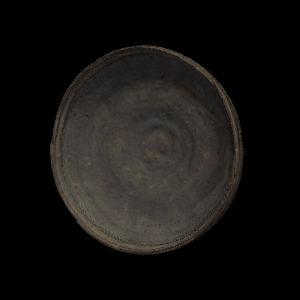

In [ ]:
import pyvista as pv

# 入力ファイル名の設定
obj_filename = "/content/repaired_mesh.obj"
texture_filename = "/content/material_0.bmp"

# 出力画像ファイル名の指定
screenshot_filename = 'screenshot_repaired_mesh.png'


# meshが定義されているファイル(obj)と，textureが定義されているファイル(bmp)を読み込む
mesh = pv.read(filename = obj_filename, force_ext = None, file_format = None, progress_bar = False)
tex = pv.read_texture(filename = texture_filename, progress_bar = False)

#plotterの用意
plotter = pv.Plotter(notebook = True, off_screen = False, window_size = [300, 300])
plotter.add_mesh(mesh = mesh, texture = tex)

# 背景色設定
plotter.set_background(color = [0, 0, 0])


#pyvistaによるカメラ位置定義
#cameraAngle_list = ['xy', 'xz', 'yz', 'yx', 'zx', 'zy', 'iso']
plotter.camera_position = 'iso'

# 方位角･仰角･偏波角 の調整
plotter.camera.elevation += 150
plotter.camera.roll += -10
plotter.camera.azimuth += 70

plotter.show(auto_close = False, screenshot = screenshot_filename)
plotter.close()